A Chemistry Solver from Scratch
=========================================

This tutorial walks you through the steps to create a new chemical kinetic rate
equation solver.  These solvers all utilize very similar structures for
calculating the right hand side and the Jacobian, and will export a
standardized API to those functions.  

While Dengo provides a number of pre-packaged rate equations, species, rate
coefficients and cooling functions, here we provide the necessary steps in
order to create new species and rates from scratch.

## Defining a Species

We start by defining individual species.  This can be done inside a python
module of your choosing, which we will run at the end to output our new
network.  Species are defined by a small number of attributes:

 * Name (which will be used in cooling functions and internally to the solver)
 * Number: Mostly unused except when handling ions.
 * Atomic weight (in integer AMU)
 * Number of free electrons that is contributes

This information is used when calculating things like the contribution of a
species to the number density.
We now have three symbolic "species" objects for hydrogen, ionized hydrogen,
and electrons.  Note that Dengo will happily create ions for species defined in
the CHIANTI database.

In [353]:
from dengo.reaction_classes import AtomicSpecies, MolecularSpecies
from dengo.chemical_network import species_registry

HI = AtomicSpecies('H', free_electrons=0.0)
HII = AtomicSpecies("H", free_electrons=1.0)
H2I = MolecularSpecies("H2", weight=2.01588, free_electrons=0.0)
de  = species_registry['de']

In the above example we utilize the `AtomicSpecies` and `MolecularSpecies`. `Dengo` will try to look for the constituent elements based on the expression from the periodic table, and assign them with appropriate weights. These elements are automatically register to `dengo.reaction_classes.species_registry`. 

Yeah you have successfully created your `ChemicalSpecies` in `Dengo`!

In [354]:
species_registry

{'ge': Species: ge,
 'de': Species: de,
 'H_1': Species: H_1,
 'H_2': Species: H_2,
 'H2_1': Species: H2_1}

Creating Reactions
------------------
Once we have the species in hand, we can then specify the reactions between these different species. Consider a simple reaction where ionized hydrogen atom recombines with an electron and gives a neural Hydrogen atom:
$$ \mathrm{H^+ + e^- \rightarrow H} $$ 
`dengo.reaction_classes.reaction` is primarily composed of:
- the name of the reaction:
```python
k01
```
- input species: 
```python
[(1, "HII"), (1, "de")]
 ```
- output species: 
```python
[(1, "HI")]
```
- reaction rates: which may depend on the temperature of the medium

In [370]:
from dengo.reaction_classes import reaction
from dengo.chemical_network import reaction_registry

tiny = 1e-60
# -- k01 --
@reaction('k01', [   (1,HI),   (1,de)], [  (1,HII),   (2,de)])
def rxn(state):
    vals = np.exp(-32.71396786375
              + 13.53655609057*state.logtev
              - 5.739328757388*state.logtev**2
              + 1.563154982022*state.logtev**3
              - 0.2877056004391*state.logtev**4
              + 0.03482559773736999*state.logtev**5
              - 0.00263197617559*state.logtev**6
              + 0.0001119543953861*state.logtev**7
              - 2.039149852002e-6*state.logtev**8)
    # taken from Abel 1999
    vals = np.maximum(vals , tiny *np.ones((len(state.T))) )
    return vals

@reaction('k02', [  (1,HII),   (1,de)], [   (1,HI),         ])
def rxn(state):
    _i1 = (state.T > 5500)
    _i2 = ~_i1
    vals = np.exp(-28.61303380689232
                  - 0.7241125657826851*state.logtev
                  - 0.02026044731984691*state.logtev**2
                  - 0.002380861877349834*state.logtev**3
                  - 0.0003212605213188796*state.logtev**4
                  - 0.00001421502914054107*state.logtev**5
                  + 4.989108920299513e-6*state.logtev**6
                  + 5.755614137575758e-7*state.logtev**7
                  - 1.856767039775261e-8*state.logtev**8
                  - 3.071135243196595e-9*state.logtev**9)
    vals[_i2] = 3.92e-13 / state.tev[_i2]**0.6353

    return vals

Similar to species, the reaction is registered in the `dengo.chemical_network.reaction_registry`, and the `dengo.reaction_classes.Reaction` is accesible through the reaction registry.

In [371]:
reaction_registry['k02'], type(reaction_registry['k02'])

(k02 : 1*H_2 + 1*de => 1*H_1, dengo.reaction_classes.Reaction)

Create Cooling Functions
------------------------------------
The release/ absorption of energy via various physical process would modify the thermal state of the medium, which might in turn accelerates/ terminates further reactions. Keeping track of the thermal energy through the course of evolution is quintessential to the accurate modeling of the process. 

`<dengo.reaction_classes.CoolingAction>` is composed of:
- name
- the cooling equation
- cooling rate

In [372]:
from dengo.reaction_classes import cooling_action
from dengo.chemical_network import cooling_registry

# -- reHII --
@cooling_action("reHII", "-reHII * HII * de")
def cool(eq):
    @eq.table
    def reHII(state):
        # (from Hui and Gnedin 1997)
        lambdaHI = 2.0 * 157807e0 / state.T
        vals = 1.778e-29 * state.T * lambdaHI**1.965 / \
         (1.0e0 + (lambdaHI/0.541)**0.502)**2.697
        return vals

In [447]:
cooling_registry['reHII'], type(cooling_registry['reHII'])

(<dengo.reaction_classes.CoolingAction at 0x7f572ebceaf0>,
 dengo.reaction_classes.CoolingAction)

Finally, we have our chemical species, reactions, cooling functions ready!

Creating a Network
------------------
We can now assemble them together in this `ChemicalNetwork`. This object helps us do all the neccessary computations to arrive at the symbolic **rhs** and **jacobian** functions, which ultimately eases us of the process of deriving them by hand. 

In our example with only two reactions, that consisted of $\rm H, H^+, e^-$. Note that in the below they represent the **number density $(\rm cm^{-3})$** of different species.

$$
    \mathrm{ H^+ + e^- \rightarrow H}
$$

$$
    \mathrm{ H + e^- \rightarrow H^+ + 2 e^-}
$$

$$
    \begin{align*}
    \mathrm{
    \frac{d H}{dt} = k_{02}(T) \,  H^+ \, e^-  - k_{01}(T) \,  H \, e^- \\
    \frac{d  H^+}{dt} = - k_{02}(T) \,  H^+ \, e^- + k_{01}(T) \,  H \, e^-  \\
    \frac{d e^-}{dt} = - k_{02}(T) \,  H^+ \, e^-  + k_{01}(T) \,  H \, e^- \\
    }
    \end{align*}
$$

We can do a quick sanity check on the conservation of the species $H$ and the charge $e^-$ and the equation above apparently satisfies our conservation law.

$$
    \frac{d}{dt} (\rm H + H^+) = 0
$$ 

$$
    \frac{d}{dt} (\rm H^+ -e^-) = 0 
$$

In [444]:
from dengo.chemical_network import ChemicalNetwork
simpleNetwork = ChemicalNetwork()
simpleNetwork.add_reaction("k01")
simpleNetwork.add_reaction("k02")
simpleNetwork.add_cooling("reHII")
simpleNetwork.init_temperature((1e0, 1e8))
simpleNetwork.enforce_conservation = True

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1


Let's see what `ChemicalNetwork` is capable of doing!

### Evaluate the temperature

The temperature $T$ as we have seen above is critical to the rate at which the reaction proceeds. The temperature can be evaluated from the internal energy term `ge`. 
Internal energy of an ideal gas is:
$$ E = \rho \epsilon = c_V T = \frac{nkT}{\gamma -1}$$
For monoatomic gas $\gamma$ is $5/3$, and diatomic gas $\gamma$ is $7/5$. $\gamma$ refers to the adiabatic constant, and it is directly related to the degree of freedom available to the species $f = \frac{2}{\gamma -1}$. When the temperature is higher, other degrees of freedom might get excited, and which leads toa temperature-dependent $\gamma$.

The total internal energy in the mixture of ideal gas is:
$$\epsilon = \sum_s \frac{n_s kT}{\gamma_s -1}$$.
$T$ can be thus be calculated from $E$ and the abundance of all the avaialble species $n_s$.

In our simple example, the internal energy can be written out plainly as

$$
\begin{align*}
\epsilon &= (\frac{n_{\rm H}}{\gamma - 1}+\frac{n_{\rm H^+}}{\gamma - 1}+\frac{n_{\rm e^-}}{\gamma - 1}) \times \frac{k T}{\rho} \\
&= \Gamma_{\rm eff} \frac{k T}{\rho} \\
T &= \frac{\rho \epsilon}{\Gamma_{\rm eff} k}
\end{align*}
$$

`Dengo` can generate the `sympy` expression of $\Gamma_{\rm eff}$ with the function `ChemicalNetwork.gamma_factor()`. We are at the position to define our our function to calculate the temperature, with the expression provided to us by `Dengo`. Notice that in `Dengo`, the internal energy term $ge$ is treated as energy per unit mass density $\epsilon = E/\rho$. You also ask `Dengo` to directly spit out the expression for temperature with `simpleNetwork.temperature_calculation()`.

In [376]:
simpleNetwork.gamma_factor()

H_1/(gamma - 1.0) + H_2/(gamma - 1.0) + de/(gamma - 1.0)

In [377]:
sorted(simpleNetwork.required_species)

[Species: H_1, Species: H_2, Species: de, Species: ge]

In [378]:
simpleNetwork.print_mass_density()

'1.0079400000000001*H_1 + 1.0079400000000001*H_2'

In [379]:
import numpy.typing as npt

gamma = 5./3.
kb    = 1.38e-16
mh    = 1.67e-24

def calculate_temperature(state: npt.ArrayLike):
    """calculate temperature in (K) based on the state space vector"""

    # extract the abundance from the state vector
    H_1, H_2, de, ge = state
    inv_gammam1 = 1 / (gamma - 1)
    gamma_factor = (H_1 + H_2 + de) * inv_gammam1
    rho = 1.00794*H_1 + 1.00794*H_2
    T = ge / gamma_factor / kb * mh * rho
    return T

### Evaluate the reaction rates
Reaction rates usually have a temperature dependence. For example, for reactions following the [Arrhenius equation](https://en.wikipedia.org/wiki/Arrhenius_equation) usually have the forms of $$k(T) = A e^{-\frac{E_a}{RT}}$$, where $k$ is the reaction rate, $E_a$ is the activation energy of the reaction, $T$ is the temperature, $A$, $R$ are the pre-exponential factor, and the universal gas constant respectively. $A$ is sometimes dependent further on temperature in [Modified Arrhenius equation](https://en.wikipedia.org/wiki/Arrhenius_equation#Modified_Arrhenius_equation).

<!-- Evaluating these rates on the fly would be computationally expensive. One possible way of reducing the computational time is to interpolate from a pre-calculated reaction rates table. The rates are specified when the reactions `rxn` are first created with the `@reaction` decorator. They can be evaluated handily with `rxn.coeff_fn(chemicalnetwork)`. The range of temperature of interest for example $T = \rm (1, 10^8) K$ can be first specified with `ChemicalNetwork.init_temperature(T_bounds=(1e0, 1e8), n_bins=1024)`. The added reaction objects can be accessed with `ChemicalNetwork.reactions`. -->

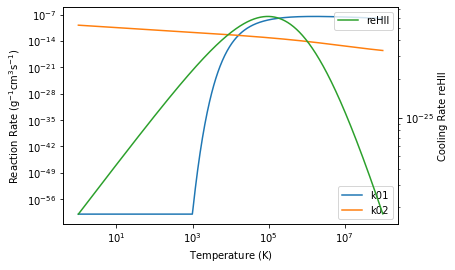

In [384]:
# The reactions in the chemical network can be assessed
import numpy as np
import matplotlib.pyplot as plt
reactions = simpleNetwork.reactions
cooling   = simpleNetwork.cooling_actions

rxnk01 = reactions['k01']
rxnk02 = reactions['k02']
reHII  = cooling['reHII']
temperature = simpleNetwork.T
rxnk01_rate = rxnk01.coeff_fn(simpleNetwork)
rxnk02_rate = rxnk02.coeff_fn(simpleNetwork)

plt.loglog(temperature, rxnk01_rate, label='k01')
plt.loglog(temperature, rxnk02_rate, label='k02')
plt.xlabel(r'Temperature $(\rm K)$')
plt.ylabel(r'Reaction Rate $(\rm g^{-1} cm^{3} s^{-1} )$')
plt.legend()
ax2 = plt.twinx()
coolreHII_rate = reHII.tables['reHII'](simpleNetwork)
ax2.loglog(temperature, coolreHII_rate,color='C2', label='reHII')
plt.ylabel(r'Cooling Rate reHII')
plt.legend()

In [387]:
logT       = np.log10(temperature)
k01lograte = np.log10(rxnk01_rate)
k02lograte = np.log10(rxnk02_rate)
coolreHII_lograte = np.log10(coolreHII_rate)

def interpolate_rates(T: npt.ArrayLike):
    """interpolate the reaction rate in log space
    
    Parameters
    ----------
        T: the temperate at which the rate is evaluated
    
    Return
    ------
        k02: interpolated reaction rate at temperature T 
    """
    k01 = 10**np.interp(np.log10(T), logT, k01lograte)
    k02 = 10**np.interp(np.log10(T), logT, k02lograte)
    return k01, k02

def interpolate_cooling_rates(T: npt.ArrayLike):
    """interpolate the cooling rate in log space
    
    Parameters
    ----------
        T: the temperate at which the rate is evaluated
    
    Return
    ------
        coolreHII_rate: interpolated cooling rate at temperature T 
    """
    coolreHII_rate = 10**np.interp(np.log10(T), logT, coolreHII_lograte)
    return coolreHII_rate

### The RHS function

The dynamics is specified by the set of ODE equations.
$$ \frac{d \bf y}{dt} = f(\bf y) $$
where $\bf y$ corresponds to the abundance vector for the species of interest, and $f(\bf y)$ describes the dynamics.

`Dengo` aggreates the reactions specific to each species $s$ with `ChemicalNetwork.species_total(s)` with `sympy` internally. These sympy expression can be exported to various different code style with `sympy.printing` to `C`, `python` for example.

In [388]:
for s in sorted(simpleNetwork.required_species):
    if s.name != 'ge':
        print(f"d{s.name:>3}dt = {simpleNetwork.species_total(s)}")
    else:
        print(f"d{s.name:>3}dt = {simpleNetwork.print_cooling(assign_to=None)}")

dH_1dt = -k01[i]*H_1*de + k02[i]*H_2*de
dH_2dt = k01[i]*H_1*de - k02[i]*H_2*de
d dedt = k01[i]*H_1*de - k02[i]*H_2*de
d gedt = -reHII_reHII[i]*H_2*de


In [397]:
def rhs_func(state, t):
    """evaluate the dydt given the state y at time t
    
    Parameters
    ----------
        state: np.ndarray
            the number density of different species
        t: float
            time
    Return
    ------
        coolreHII_rate: interpolated cooling rate at temperature T 
    """
    H_1, H_2, de, ge = state
    
    T   = calculate_temperature(state)
    k01, k02 = interpolate_rates    (T)
    rho = 1.00794*H_1 + 1.00794*H_2
    
    reHII_reHII = interpolate_cooling_rates(T)
    
    dH_1dt = k02*H_2*de - k01*H_1*de
    dH_2dt = -k02*H_2*de + k01*H_1*de
    ddedt = -k02*H_2*de + k01*H_1*de
    dgedt = (-reHII_reHII*H_2*de)/ rho /mh
    
    dstatedt = np.array([dH_1dt,dH_2dt,ddedt,dgedt])
    return dstatedt

### Integrate the System
Once the RHS function is specified, we are ready to evolve the system. Here we will use the `scipy.integrate.odeint` to integrate the ODE. The initial value are specified below as a 1D-vector. And the output logarithmically-spaced timesteps are also fed into the ODE solver. 

In [450]:
# Prepare the initial state vector
ge = 1e13  #erg/g
H_1 = 1e-2# 1/cm^3
H_2 = 1e-2# 1/cm^3
de  = 1e-2# 1/cm^3
state = np.array([H_1, H_2, de, ge])

In [442]:
from scipy.integrate import odeint

timesteps = np.logspace(10, 16,101)
output     = odeint(rhs_func, state, t=timesteps)

/tmp/ipykernel_39991/2785043320.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  f.legend(


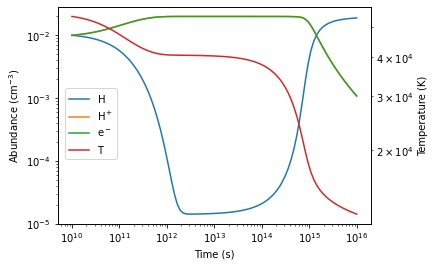

In [443]:
H_1_traj, H_2_traj, de_traj, ge_traj = output.T

f, ax = plt.subplots()
l1= ax.loglog(timesteps, H_1_traj)
l2= ax.loglog(timesteps, H_2_traj)
l3= ax.loglog(timesteps, de_traj)
ax2 = ax.twinx()
T_traj = calculate_temperature(output.T)
l4= ax2.loglog(timesteps, T_traj, color='C3')


ax.set_ylabel(r"Abundance ($\rm cm^{-3}$)")
ax2.set_ylabel("Temperature (K)")

ax.set_xlabel("Time (s)")

f.legend(
    [l1,l2,l3,l4], 
    labels=[r'$\rm H$',r'$\rm H^+$',r'$\rm e^-$',r'$\rm T$'],
    loc=[0.15,0.4]
)
plt.subplots_adjust(right=0.85)

In [451]:
rhs_func(state,0)

array([-6.76258746e-14,  6.76258746e-14,  6.76258746e-14, -1.78976746e-03])

### Summary
1. We have built a reaction chemical network with 2 reactions and 1 cooling action from scratch with `Dengo`!
2. We demonstrated how can we build a simple ODE solver with the symbolic outputs from `Dengo`!

In the next chapter, we demonstrate how `Dengo` can be used in conjunction with `Jinja2` to write a solver for arbitary network in the next chapter.
